In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import warnings

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [2]:
_h = 20
_d = _h*24
_w = _d*7

### Load dataset

In [3]:
series = pd.read_csv('dataset/people.csv')
series['datetime'] = pd.to_datetime(series['datetime'])

In [4]:
series.head()

,datetime,zone1,zone2,zone3,zone4
0,2020-12-15 22:01:44,0,2,0,3
1,2020-12-15 22:03:32,0,0,0,3
2,2020-12-15 22:05:09,0,0,0,4
3,2020-12-15 22:06:45,0,0,0,4
4,2020-12-15 22:08:15,0,0,0,2


In [5]:
series = series.groupby(pd.Grouper(freq='5T',key='datetime')).mean()
series

,zone1,zone2,zone3,zone4
datetime,,,,
2020-12-03 12:05:00,5.0,0.0,0.0,3.0
2020-12-03 12:10:00,NaN,NaN,NaN,NaN
2020-12-03 12:15:00,NaN,NaN,NaN,NaN
2020-12-03 12:20:00,NaN,NaN,NaN,NaN
2020-12-03 12:25:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2021-01-11 10:05:00,NaN,NaN,NaN,NaN
2021-01-11 10:10:00,NaN,NaN,NaN,NaN
2021-01-11 10:15:00,0.0,0.0,0.0,2.0


In [6]:
series.fillna(method='ffill', inplace=True)
series = series.round()

In [7]:
Last = series.index[-1]
Last

Timestamp('2021-01-11 10:25:00', freq='5T')

### Split data into train and test sets (75 : 25)

In [8]:
X = series['zone1'].values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:]
history = [x for x in train]
predictions = list()

### I trained model in only zone1 and use this model to evaluate other zones.

### Walk-forward validation

In [9]:
pred = []
for t in range(len(test)):
    model = ARIMA(history, order=(20,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = round(output[0])
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    pred.append(yhat)

In [10]:
model_fit.save('model_zone1.pkl')

### Evaluate forecasts

In [11]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.374


### Forcast

In [12]:
def Prdict(model, period):
    if(period == 'hour'):
        time = _h
    elif(period == 'day'):
        time = _d
    elif(period == 'week'):
        time = _w
        
    new = pd.DataFrame(pd.date_range(Last, freq='5min', periods= time))
    new.set_index(0, inplace = True)
    ppre = model_fit.predict(1,time)
    ppre = ppre.reshape(-1,1)
    new['Zone1'] = ppre.round()
    plt.scatter(new.index,new['Zone1'], s= 1)

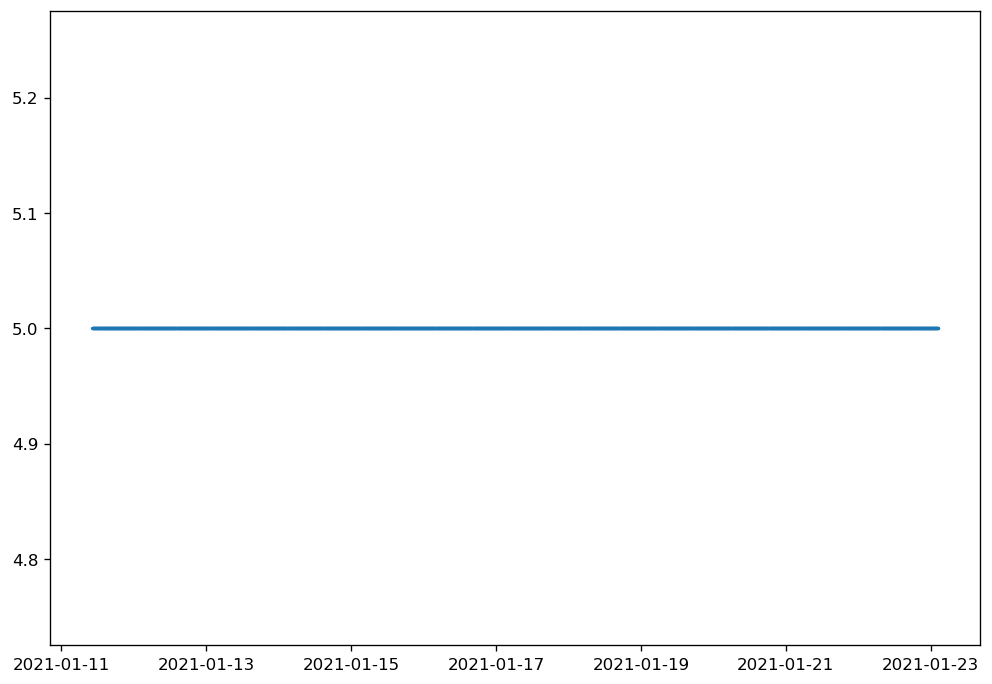

In [14]:
Prdict(model_fit, 'week')